<a href="https://colab.research.google.com/github/arunimamuralitharan/aitask/blob/main/data1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!pip install pydub

Mounted at /content/drive


In [ ]:
import os
import shutil
import pandas as pd
from pydub import AudioSegment
from pydub.utils import make_chunks
from tqdm import tqdm  # progress bar

# config
INPUT_ROOT = "/content/drive/MyDrive/thesis_raw_data"

CHUNK_LENGTH_MS = 30000  # 30 seconds
TEMP_OUTPUT_DIR = "/content/processed_dataset" # local colab storage
METADATA_FILE = "/content/metadata.csv"

def process_colab_folder(label_name, label_code):
    # construct path: /content/drive/MyDrive/thesis_raw_data/aphasia
    folder_path = os.path.join(INPUT_ROOT, label_name)
    data_records = []

    if not os.path.exists(folder_path):
        print(f"Error: Path not found: {folder_path}")
        return []

    files = [f for f in os.listdir(folder_path) if f.endswith('.wav')]
    print(f"\nProcessing {label_name} ({len(files)} files)")

    for file in tqdm(files):
        file_path = os.path.join(folder_path, file)
        filename_base = os.path.splitext(file)[0]

        try:
            # load audio
            audio = AudioSegment.from_file(file_path)
            audio = audio.set_frame_rate(16000).set_channels(1)

            # chunk
            chunks = make_chunks(audio, CHUNK_LENGTH_MS)

            for i, chunk in enumerate(chunks):
                if len(chunk) < 10000: continue # skip silence and small chunks

                chunk_name = f"{label_name}_{filename_base}_{i}.wav"
                out_path = os.path.join(TEMP_OUTPUT_DIR, chunk_name)

                chunk.export(out_path, format="wav")

                data_records.append({"file_name": chunk_name, "label": label_code})

        except Exception as e:
            print(f"Failed: {file} | Error: {e}")

    return data_records

# execution
if os.path.exists(TEMP_OUTPUT_DIR):
    shutil.rmtree(TEMP_OUTPUT_DIR) # clean up previous runs
os.makedirs(TEMP_OUTPUT_DIR)

# run processing
aphasia_data = process_colab_folder("aphasia", 1)
healthy_data = process_colab_folder("healthy", 0)

# save csv
df = pd.DataFrame(aphasia_data + healthy_data)
df.to_csv(METADATA_FILE, index=False)

print(f"\n successfully created {len(df)} chunks.")

/usr/local/lib/python3.12/dist-packages/pydub/utils.py:300: SyntaxWarning: invalid escape sequence '\('
  m = re.match('([su]([0-9]{1,2})p?) \(([0-9]{1,2}) bit\)$', token)
/usr/local/lib/python3.12/dist-packages/pydub/utils.py:301: SyntaxWarning: invalid escape sequence '\('
  m2 = re.match('([su]([0-9]{1,2})p?)( \(default\))?$', token)
/usr/local/lib/python3.12/dist-packages/pydub/utils.py:310: SyntaxWarning: invalid escape sequence '\('
  elif re.match('(flt)p?( \(default\))?$', token):
/usr/local/lib/python3.12/dist-packages/pydub/utils.py:314: SyntaxWarning: invalid escape sequence '\('
  elif re.match('(dbl)p?( \(default\))?$', token):



Processing aphasia (6 files)


100%|██████████| 6/6 [01:38<00:00, 16.48s/it]



Processing healthy (4 files)


100%|██████████| 4/4 [00:18<00:00,  4.56s/it]


 successfully created 815 chunks.


In [ ]:
import shutil

zip_name = "final_thesis_dataset_demo1"

print("Zipping files...")
shutil.make_archive(f"/content/{zip_name}", 'zip', TEMP_OUTPUT_DIR)

destination = "/content/drive/MyDrive/"
print(f"Moving {zip_name}.zip to Google Drive...")
shutil.copy(f"/content/{zip_name}.zip", destination)
shutil.copy(METADATA_FILE, destination)

print("\n Created. Check Drive for 'final_thesis_dataset_demo1.zip' and 'metadata.csv'.")

Zipping files...
Moving final_thesis_dataset_demo1.zip to Google Drive...

 Created. Check Drive for 'final_thesis_dataset_demo1.zip' and 'metadata.csv'.


In [ ]:
import librosa
import os
folder = "/content/temp_dataset"
filename = os.listdir(folder)[0]
path = os.path.join(folder, filename)

y, sr = librosa.load(path, sr=None)
print(f"File: {filename}")
print(f"Sample Rate: {sr} Hz")

File: aphasia_1554_38.wav
Sample Rate: 16000 Hz


Mounting Google Drive...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

⚡ Files already unzipped. Skipping extraction.

Reading Metadata from /content/drive/MyDrive/metadata.csv...
Loaded 815 records.
Loading Healthy Audio: healthy_SBC059_16.wav...
Loading Aphasia Audio: aphasia_1944_45.wav...

Generating Visuals...

Success. Image saved to: /content/dataset_analysis.png


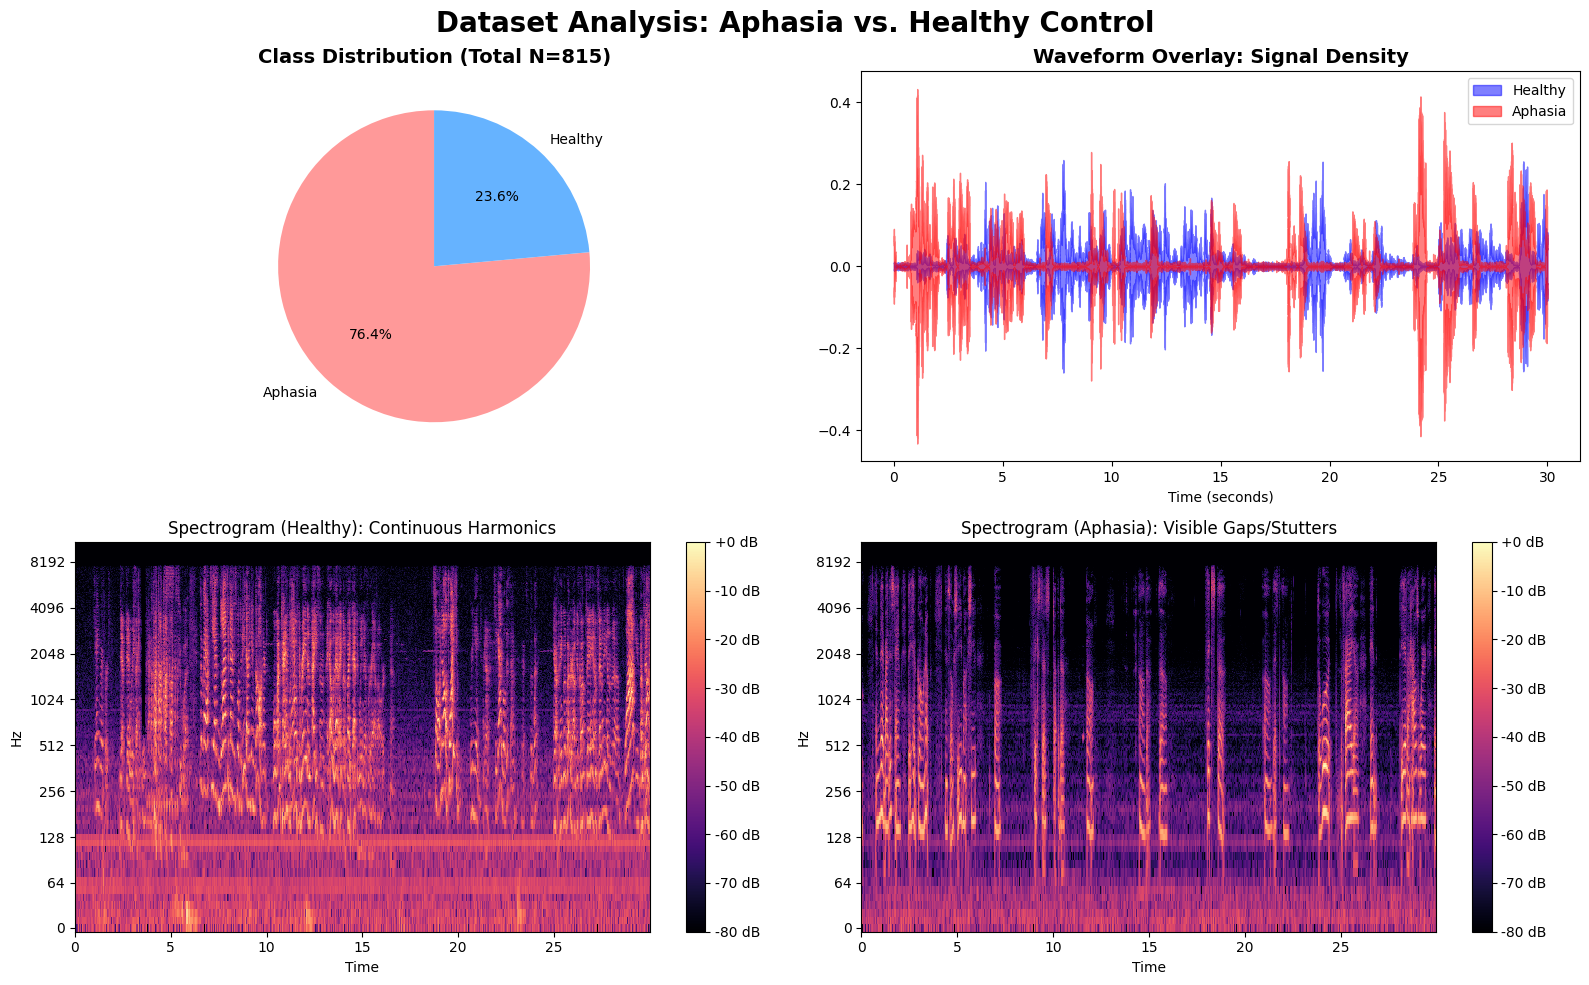

In [ ]:
import os
import zipfile
import pandas as pd
import matplotlib.pyplot as plt
import librosa
import librosa.display
import numpy as np
from google.colab import drive

print("Mounting Google Drive...")
drive.mount('/content/drive')

ZIP_PATH = "/content/drive/MyDrive/final_thesis_dataset_demo1.zip"
CSV_PATH = "/content/drive/MyDrive/metadata.csv"
EXTRACT_PATH = "/content/temp_dataset"

def visualize_dataset():
    if not os.path.exists(EXTRACT_PATH):
        print(f"\nUnzipping '{ZIP_PATH}'...")
        try:
            with zipfile.ZipFile(ZIP_PATH, 'r') as zip_ref:
                zip_ref.extractall(EXTRACT_PATH)
            print("Unzip complete!")
        except FileNotFoundError:
            print(f"ERROR: Zip file not found at {ZIP_PATH}")
            return
    else:
        print("\n⚡ Files already unzipped. Skipping extraction.")

    print(f"\nReading Metadata from {CSV_PATH}...")
    try:
        df = pd.read_csv(CSV_PATH)
        print(f"Loaded {len(df)} records.")
    except FileNotFoundError:
        print(f"ERROR: CSV file not found at {CSV_PATH}")
        return

    try:
        healthy_row = df[df['label'] == 0].sample(1).iloc[0]
        aphasia_row = df[df['label'] == 1].sample(1).iloc[0]

        h_file = os.path.join(EXTRACT_PATH, healthy_row['file_name'])
        a_file = os.path.join(EXTRACT_PATH, aphasia_row['file_name'])

        print(f"Loading Healthy Audio: {healthy_row['file_name']}...")
        y_h, sr_h = librosa.load(h_file)

        print(f"Loading Aphasia Audio: {aphasia_row['file_name']}...")
        y_a, sr_a = librosa.load(a_file)

    except Exception as e:
        print(f"Error loading audio files: {e}")
        print("Check if the filenames in CSV match the unzipped files.")
        return

    print("\nGenerating Visuals...")
    fig = plt.figure(figsize=(16, 10))
    plt.suptitle("Dataset Analysis: Aphasia vs. Healthy Control", fontsize=20, weight='bold')

    # 1. Class Balance (Pie Chart)
    ax1 = plt.subplot(2, 2, 1)
    counts = df['label'].value_counts()
    labels = ['Aphasia', 'Healthy'] if counts.index[0] == 1 else ['Healthy', 'Aphasia']
    colors = ['#ff9999','#66b3ff']
    ax1.pie(counts, labels=labels, autopct='%1.1f%%', startangle=90, colors=colors)
    ax1.set_title(f"Class Distribution (Total N={len(df)})", fontsize=14, weight='bold')

    # 2. Waveform Comparison
    ax2 = plt.subplot(2, 2, 2)
    librosa.display.waveshow(y_h, sr=sr_h, alpha=0.5, color='blue', label='Healthy')
    librosa.display.waveshow(y_a, sr=sr_a, alpha=0.5, color='red', label='Aphasia')
    ax2.set_title("Waveform Overlay: Signal Density", fontsize=14, weight='bold')
    ax2.legend(loc='upper right')
    ax2.set_xlabel("Time (seconds)")

    # 3. Spectrogram (Healthy)
    ax3 = plt.subplot(2, 2, 3)
    D_h = librosa.amplitude_to_db(np.abs(librosa.stft(y_h)), ref=np.max)
    librosa.display.specshow(D_h, sr=sr_h, x_axis='time', y_axis='log')
    ax3.set_title("Spectrogram (Healthy): Continuous Harmonics", fontsize=12)
    plt.colorbar(format='%+2.0f dB')

    # 4. Spectrogram (Aphasia)
    ax4 = plt.subplot(2, 2, 4)
    D_a = librosa.amplitude_to_db(np.abs(librosa.stft(y_a)), ref=np.max)
    librosa.display.specshow(D_a, sr=sr_a, x_axis='time', y_axis='log')
    ax4.set_title("Spectrogram (Aphasia): Visible Gaps/Stutters", fontsize=12)
    plt.colorbar(format='%+2.0f dB')

    plt.tight_layout()

    # Save Image
    save_path = "/content/dataset_analysis.png"
    plt.savefig(save_path, dpi=300)
    print(f"\nSuccess. Image saved to: {save_path}")
    plt.show()

visualize_dataset()